In [38]:
import torch
import pickle
import string
import emoji
import re
import contractions
import pandas as pd
import torch.nn as nn
import dill
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his",
              "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", 
              "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had",
              "having", "do", "does", "did", "doing", "a", "an", "the", "and", "if", "or", "because", "as", "until", "while", "of", "at",
              "by", "for", "with", "about", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from",
              "up", "down", "in", "on", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why",
              "how", "all", "any", "both", "each", "other", "some", "such", "own", "same", 
              "than", "too", "now"]
punctuation_chars = string.punctuation
regrex_pattern = f"[{re.escape(punctuation_chars)}]"
url_pattern = r"https?://\S+|www\.\S+"


In [3]:
def convert_emojis_to_words(text):
    return emoji.demojize(text,delimiters=(" ", " "))

def remove_html_tag(text):
    return re.sub(r'<.*?>', '', text)
    
def clean_text(text):
    text = convert_emojis_to_words(text)
    text = re.sub(url_pattern,"",text)  #remove URLS
    text = remove_html_tag(text)
    expanded = contractions.fix(text).lower()
    cleaned_text = re.sub(r'\d+',"", expanded) #remove numbers
    
    punctuation_remove = re.sub(regrex_pattern,"",cleaned_text)
    # print(punctuation_remove)
    cleaned_token = [token for token in punctuation_remove.split(" ") if token not in stop_words]
    return " ".join(cleaned_token)
    # return punctuation_remove

def padding_text(text, max_length=128):
    if ((max_length - len(text)) < 0):
        return text[:max_length-len(text)]
    padded_sequence = text + [0] * (max_length - len(text))
    return padded_sequence

clean_text( "This isn't good123 me live ")

'not good live '

In [4]:
class Tokenization():
    def __init__(self,data):
        self.data = data
        # print(data)
        all_words = " ".join(self.data).lower().split()

        self.vocab = set(all_words)
        pad_unknown = {"<PAD>":0,"<UNK>":1}
        self.word2idx = {word: i+2 for i, word in enumerate(self.vocab)}  #  0 for padding and 1 for Unknown
        self.word2idx.update(pad_unknown)

    def encode(self,text):
        encoded = []
        for word in text.lower().split():
            if word in self.vocab:
                encoded.append(self.word2idx[word])
            else:
                encoded.append(1)
            
        return encoded

    def decode(self,encode_text):
        print(encode_text)
        decode_list = []
        for token in encode_text:
            for key,value in self.word2idx.items():
                if token==value:
                    decode_list.append(key)
        return " ".join(decode_list)
                    



In [5]:
class CustomLSTMCell(nn.Module):
    def __init__(self,input_size, hidden_size,hidden_layer=False):
        super(CustomLSTMCell,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.hidden_layer = hidden_layer

        #gate's Fully connected network
        if hidden_layer:
            self.combined_linear = nn.Linear(self.input_size+self.hidden_size,128)
            self.combined_linear2 = nn.Linear(128,4*self.hidden_size)
        else:
            self.combined_linear = nn.Linear(self.input_size+self.hidden_size,4*self.hidden_size)
            
        self.layer_norm = nn.LayerNorm(hidden_size)
        

    def forward(self, x, hidden_state, cell_state):
        input_hidden = torch.concat([x,hidden_state],dim=1)
        
        if self.hidden_layer:
            x = self.combined_linear(input_hidden)
            combined_linear = self.combined_linear2(torch.relu(x))
        else:
            combined_linear = self.combined_linear(input_hidden)

        f_t,i_t,ic_t,o_t = torch.chunk(combined_linear,4,dim=1)
        # forget gate 
        f_t = torch.sigmoid(f_t)
        #input gate
        i_t = torch.sigmoid(i_t)
        ic_t = torch.tanh(ic_t)

        #output_gate
        o_t = torch.sigmoid(o_t)

        c_t = cell_state * f_t  + i_t * ic_t  #cell state of current lstm

        h_t = o_t * torch.tanh(c_t)   #hidden state of current lstm [batch, hidden_size]

        return h_t, c_t



class CustomLSTM(nn.Module):
    def __init__(self,input_size, hidden_size,hidden_layer=False):
        super(CustomLSTM,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.hidden_layer = hidden_layer

        self.LSTM_cell = CustomLSTMCell(self.input_size,self.hidden_size,self.hidden_layer)

    def forward(self,x):
        batch,padded_size,embedding_dim = x.shape
        h_t = torch.zeros(batch,self.hidden_size).to(x.device)  #initializing hidden state
        c_t = torch.zeros(batch,self.hidden_size).to(x.device)   #initializing cell state

        outputs =  torch.zeros(batch,padded_size,self.hidden_size,device=x.device)
        
        #loop through each word in sequence to their find hidden_state
        for t in range(padded_size):
            x_t = x[:, t, :]
            h_t, c_t = self.LSTM_cell(x_t, h_t, c_t)
            outputs[:, t, :] = h_t  #[batch,seq_len,hidden_size]
        return outputs

In [6]:
class Attention(nn.Module):
    def __init__(self,input_size):
        super(Attention,self).__init__()
        self.hidden_size = input_size
        self.attention = nn.Linear(self.hidden_size,1)
    
    def forward(self, x, mask=None):
        attention_score = self.attention(x).squeeze(-1)  #[batch,seq_len,1]
        
        if mask is not None:
            attention_score = attention_score.masked_fill(mask == 0, -1e9)

        attention_weight = torch.softmax(attention_score, dim=1)  #softmax on sequence to calculate probability [batch,seq_len]
        
        attn_weights_expanded = attention_weight.unsqueeze(-1)  #[batch,seq_len] --> [batch,seq_len, 1]  [[[1],[2],[3]]]=[1,3,1]
        weighted_output = x * attn_weights_expanded     #hidden state multiply with atten_weight => [batch,seq_len,hidden_state] * 
                                                        #[batch,seq_len,hidden_state] * [batch,seq_len,1] = 
                                                        # [batch,seq_len,hidden_state] this determine the importance of each word in sequence
        context_vector = weighted_output.sum(dim=1)     #find the summary of sequence [batch,hidden_state]

        return context_vector, attention_weight

In [7]:
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_dim, padding_idx=0,hidden_layer=False):
        super(SentimentModel, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.lstm1 = CustomLSTM(embedding_dim, hidden_size,hidden_layer)
        self.ln1 = nn.LayerNorm(hidden_size)

        self.lstm2 = CustomLSTM(hidden_size, hidden_size,hidden_layer)
        self.ln2 = nn.LayerNorm(hidden_size)  

        self.attention = Attention(hidden_size)
        
        self.fc = nn.Linear(hidden_size, output_dim)
        self.dropout_fc = nn.Dropout(0.3)
        
    def forward(self,x,mask=None):
        x = self.embedding(x)
        x = self.lstm1(x)
   
        x = self.ln1(x)
        
        x = self.lstm2(x)
        x = self.ln2(x)        
        x, attn_weight = self.attention(x,mask)
        
        x = self.fc(x)
        output = self.dropout_fc(x)
        
        return output,attn_weight
        

In [8]:
with open(r"C:\Users\Dell\Downloads\tokenizer.pt", "rb") as f:
    token1 = dill.load(f)           #loading tokenizer

In [9]:
token1.encode("nice saree")

[21063, 7024]

In [10]:
# train_model1 = torch.jit.load(r"C:\Users\Dell\Downloads\sentiment1.pt", map_location="cpu")

In [11]:
train_model = torch.jit.load(r"C:\Users\Dell\Downloads\sentiment2.pt", map_location="cpu")

In [ ]:
def predict(text,model):
    text = clean_text(text)
    encode = token1.encode(text)
    padding = padding_text(encode)
    text_tensor = torch.tensor([padding], dtype=torch.long)
    model.eval()
    with torch.no_grad():
        outputs,_= model(text_tensor)  # raw logits
        probs = torch.softmax(outputs, dim=1)  # convert to probabilities
        preds = torch.argmax(probs, dim=1)     # get predicted class index
        
    label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    print("Prediction:", label_map.get(preds.item(), "Unknown"))

    return preds, probs
    

In [13]:
# train_model1

In [14]:
train_model

RecursiveScriptModule(
  original_name=SentimentModel
  (embedding): RecursiveScriptModule(original_name=Embedding)
  (lstm1): RecursiveScriptModule(
    original_name=CustomLSTM
    (LSTM_cell): RecursiveScriptModule(
      original_name=CustomLSTMCell
      (combined_linear): RecursiveScriptModule(original_name=Linear)
      (layer_norm): RecursiveScriptModule(original_name=LayerNorm)
    )
  )
  (ln1): RecursiveScriptModule(original_name=LayerNorm)
  (lstm2): RecursiveScriptModule(
    original_name=CustomLSTM
    (LSTM_cell): RecursiveScriptModule(
      original_name=CustomLSTMCell
      (combined_linear): RecursiveScriptModule(original_name=Linear)
      (layer_norm): RecursiveScriptModule(original_name=LayerNorm)
    )
  )
  (ln2): RecursiveScriptModule(original_name=LayerNorm)
  (attention): RecursiveScriptModule(
    original_name=Attention
    (attention): RecursiveScriptModule(original_name=Linear)
  )
  (fc): RecursiveScriptModule(original_name=Linear)
  (dropout_fc): Recur

In [17]:
predict("This is awesome book", train_model)

Prediction: Positive


(tensor([2]), tensor([[3.4840e-04, 2.3160e-03, 9.9734e-01]]))

In [28]:
def batch_predict(texts,mod):
    text_df = pd.Series(texts)
    clean = text_df.apply(clean_text)
    encode = clean.apply(token1.encode)
    padding = encode.apply(padding_text)
    mod.eval()
    text_tensor = torch.tensor(padding, dtype=torch.long)

    with torch.no_grad():
        outputs,_ = mod(text_tensor)  # raw logits
        probs = torch.softmax(outputs, dim=1)  # convert to probabilities
        preds = torch.argmax(probs, dim=1)     # get predicted class index
        

    return preds.cpu()
    

def label(texts,predict):
    for x,i in zip(texts,predict):
        if (i==0):
            print(f"{x} \n \033[1mNegative\033[0m")
        elif (i==1):
            print(f"{x}\n \033[1mNeutral\033[0m")
        else:
            print(f"{x}\n \033[1mPOSITIVE\033[0m")

In [32]:
demo_text = [
    "I see what you mean.",
    "This is the best product",
    "ok ok",
    "Nice product",
    "The battery is not good"
]

In [31]:
demo_predict = batch_predict(demo_text, train_model)
label(demo_text,demo_predict)

I see what you mean.
 Neutral
This is the best product
 POSITIVE
ok ok
 Neutral
Nice product
 POSITIVE
The battery is not good 
 Negative


In [61]:
def visualize_attn(model,text):
    real_text = text
    plt.figure(figsize=(6,3))
    text = clean_text(real_text)
    encode = token1.encode(text)
    padding = padding_text(encode)
    text_tensor = torch.tensor([padding], dtype=torch.long)
    model.eval()
    with torch.no_grad():
        outputs,attn_weight= model(text_tensor)
        probs = torch.softmax(outputs, dim=1)  # convert to probabilities
        preds = torch.argmax(probs, dim=1) 
        
    label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    X = np.array(attn_weight[0][:len(encode)])
    y = text.split(" ")
    sns.barplot(x = y,y=X)
    print(real_text)
    print("Prediction:", label_map.get(preds.item(), "Unknown"))
    print("Sentiment Score: ", probs)


This is the amazing phone
Prediction: Positive
Sentiment Score:  tensor([[7.6722e-06, 1.3129e-05, 9.9998e-01]])


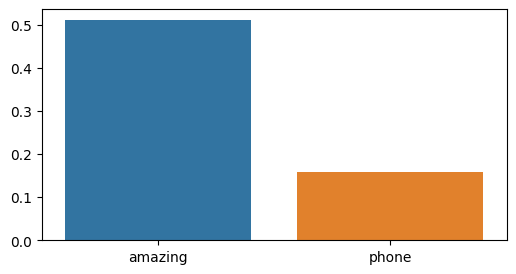

In [62]:
visualize_attn(train_model,"This is the amazing phone")

what a nice phone
Prediction: Positive
Sentiment Score:  tensor([[0.0479, 0.0753, 0.8768]])


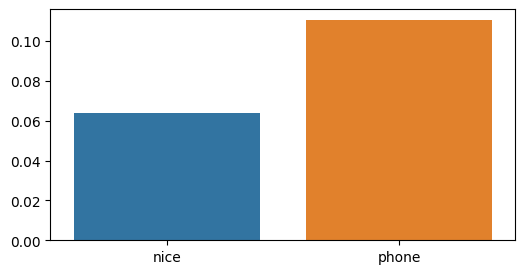

In [63]:
visualize_attn(train_model,"what a nice phone")

Not sure how I feel about this yet
Prediction: Neutral
Sentiment Score:  tensor([[0.0750, 0.9049, 0.0201]])


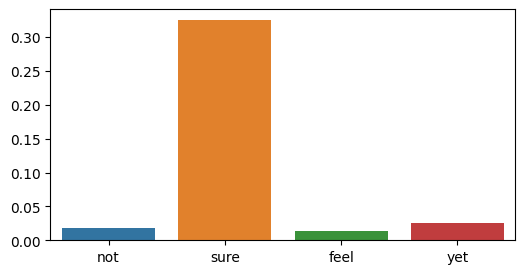

In [64]:
visualize_attn(train_model,"Not sure how I feel about this yet")

The battery life on this phone is terrible
Prediction: Negative
Sentiment Score:  tensor([[9.9992e-01, 6.0907e-06, 7.5571e-05]])


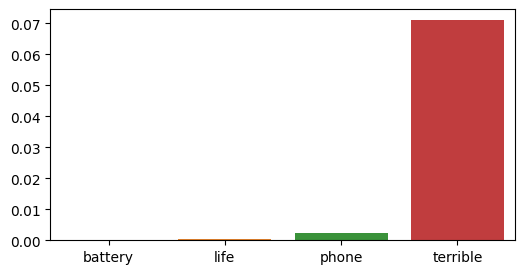

In [65]:
visualize_attn(train_model,"The battery life on this phone is terrible")

In [54]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")